# AlexNet
## Reference
1. Paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf 

## Architecure
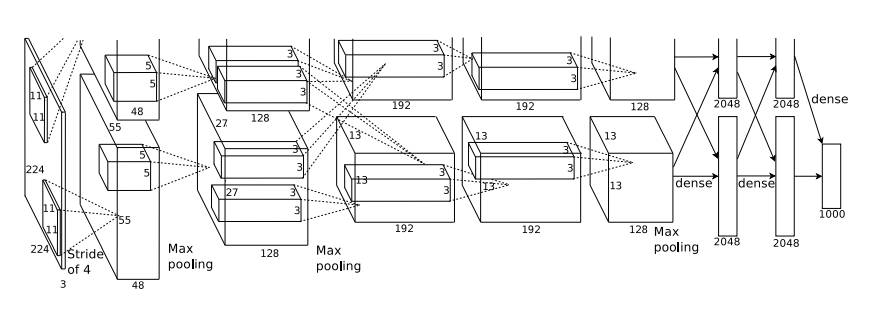

weight는 평균이 0, 분산이 0.01인 정규분포로 초기화 했다. 2, 4, 5, FC layer의 bias는 1, 나머지 layer의 bias는 0으로 초기화했다.

In [1]:
import tensorflow as tf

In [160]:
class Conv2d(tf.keras.layers.Layer):
  def __init__(
    self,
    filters,
    kernel_size,
    strides = (1, 1),
    padding = 'valid',
    kernel_initializer = 'normal',
    kernel_regularizer = None,
    use_bias = True,
    bias_initializer = 'zeros',
    bias_regularizer = None,
    activation = None,
    trainable = True,
    name = None,
    **kwargs
  ):
    super(Conv2d, self).__init__(name = name, **kwargs)
    self.filters = filters
    if isinstance(kernel_size, int):
      self.kernel_size = [kernel_size] * 2
    elif isinstance(kernel_size, tuple):
      self.kernel_size = list(kernel_size)

    if isinstance(strides, int):
      self.strides = [strides] * 2
    elif isinstance(strides, tuple):
      self.strides = list(strides)

    self.padding = padding
    self.kernel_initializer = kernel_initializer
    self.kernel_regularizer = kernel_regularizer
    self.use_bias = use_bias
    self.bias_initializer = bias_initializer
    self.bias_regularizer = bias_regularizer
    self.activation = activation
    self.trainable = trainable

  def build(self, input_shape):
    super(Conv2d, self).build(input_shape)
    self.kernel = self.add_weight(name = 'kernel',
                                  shape = self.kernel_size + [input_shape[-1], self.filters],
                                  initializer = tf.keras.initializers.get(self.kernel_initializer),
                                  regularizer = tf.keras.regularizers.get(self.kernel_regularizer),
                                  trainable = self.trainable)
    self.kernel = self.kernel * 0.01
    
    if self.use_bias:
      self.bias = self.add_weight(name = 'bias',
                                  shape = (self.filters,),
                                  initializer = tf.keras.initializers.get(self.bias_initializer),
                                  regularizer = tf.keras.regularizers.get(self.bias_regularizer),
                                  trainable = self.trainable)

  def call(self, inputs):
    conv = tf.nn.convolution(inputs,
                             filters = self.kernel,
                             strides = self.strides,
                             padding = self.padding.upper(),
                             data_format = 'NHWC')
    if self.use_bias:
      conv += self.bias

    if self.activation:
      conv = self.activation(conv)

    return conv

In [3]:
class LRN(tf.keras.layers.Layer):
  def __init__(
      self,
      depth = 5,
      bias = 2,
      alpha = 1e-4,
      beta = 0.75,
      name = None,
      **kwargs
  ):
    super(LRN, self).__init__(name = name, **kwargs)
    self.depth = depth
    self.bias = bias
    self.alpha = alpha
    self.beta = beta

  def call(self, inputs):
    lrn = tf.nn.local_response_normalization(inputs,
                                             depth_radius = self.depth,
                                             bias = self.bias,
                                             alpha = self.alpha,
                                             beta = self.beta)
    
    return lrn

In [192]:
class FC(tf.keras.layers.Layer):
  def __init__(
      self,
      units,
      kernel_initializer = 'normal',
      kernel_regularizer = None,
      activation = None,
      use_bias = True,
      bias_initializer = 'zeros',
      bias_regularizer = None,
      trainable = True,
      name = None,
      **kwargs
  ):
    super(FC, self).__init__(name = name, **kwargs)
    self.units = units
    self.kernel_initializer = kernel_initializer
    self.kernel_regularizer = kernel_regularizer
    self.activation = activation
    self.use_bias = use_bias
    self.bias_initializer = bias_initializer
    self.bias_regularizer = bias_regularizer
    self.trainable = trainable
    
  def build(self, input_shape):
    super(FC, self).build(input_shape)
    self.weight = self.add_weight(name = 'weight',
                                  shape = [input_shape[-1], self.units],
                                  initializer = tf.keras.initializers.get(self.kernel_initializer),
                                  regularizer = tf.keras.regularizers.get(self.kernel_regularizer),
                                  trainable = self.trainable)
    self.weight = self.weight * 0.01
    
    if self.use_bias:
      
      if isinstance(self.bias_regularizer, tuple):
        raise ValueError('Tuple')
      self.bias = self.add_weight(name = 'bias',
                                  shape = [1, self.units],
                                  initializer = tf.keras.initializers.get(self.bias_initializer),
                                  regularizer = tf.keras.regularizers.get(self.bias_regularizer),
                                  trainable = self.trainable)
      
  def call(self, inputs):
    fc = tf.linalg.matmul(inputs, self.weight)

    if self.use_bias:
      fc += self.bias

    if self.activation:
      fc = self.activation(fc)

    return fc

In [5]:
class Concat(tf.keras.layers.Layer):
  def __init__(self, axis = -1):
    super(Concat, self).__init__()
    self.axis = axis

  def call(self, inputs):
    concat = tf.concat(inputs, axis = self.axis)
    return concat

In [7]:
class Dropout(tf.keras.layers.Layer):
  def __init__(
      self,
      rate,
      noise_shape = None,
      name = None,
      **kwargs):
    super(Dropout, self).__init__(name = name, **kwargs)
    self.rate = rate
    self.noise_shape = noise_shape

  def call(self, inputs):
    dropout = tf.nn.dropout(inputs,
                            rate = self.rate,
                            noise_shape = self.noise_shape)
    return dropout

In [200]:
class AlexNet(tf.keras.Model):
  def __init__(
      self,
      architecture,
      num_class = 10,
      name = 'AlexNet',
      **kwargs):
    '''
    architecture = {'layer1':[48, 11, 4, 'zeros'],
                    'layer2':[128, 5, 2, 'ones'], 
                    'layer3':[192, 3, 2, 'zoers'],
                    'layer4':[192, 3, 1, 'ones'],
                    'layer5':[128, 3, 1, 'ones'],
                    'fc':2048,
                    'rate': 0.5,}
    '''
    super(AlexNet, self).__init__(name = name, **kwargs)
    self.architecture = architecture
    self.net_layers = {}
    for stage, arch in enumerate(architecture.values()):
      if isinstance(arch, list):
        for block in range(2):
          self.net_layers[f'conv_{stage}-{block}'] = Conv2d(filters = arch[0],
                                                            kernel_size = arch[1],
                                                            strides = arch[2],
                                                            bias_initializer = arch[3],
                                                            activation = tf.nn.relu)
          self.net_layers[f'lrn_{stage}-{block}'] = LRN()
        if stage == 0 or stage == 4:
          self.net_layers[f'concat_{stage}'] = Concat()
      if isinstance(arch, int):
        for i in range(2):
          self.net_layers[f'fc_{i}'] = FC(arch)
      if isinstance(arch, float):
        for i in range(2):
          self.net_layers[f'dropout_{i}'] = Dropout(arch)
    self.net_layers[f'fc_3'] = FC(num_class)
  
  def call(self, inputs):
    for stage in range(5):
      if stage == 0:
        x1 = self.net_layers[f'conv_{stage}-0'](inputs)
        x1 = self.net_layers[f'lrn_{stage}-0'](x1)
        x2 = self.net_layers[f'conv_{stage}-1'](inputs)
        x2 = self.net_layers[f'lrn_{stage}-1'](x2)
        concat = self.net_layers[f'concat_{stage}']([x1, x2])
      elif stage == 1:
        x1 = self.net_layers[f'conv_{stage}-0'](concat)
        x1 = self.net_layers[f'lrn_{stage}-0'](x1)
        x2 = self.net_layers[f'conv_{stage}-1'](concat)
        x2 = self.net_layers[f'lrn_{stage}-1'](x2)
      elif 1 < stage < 4:
        x1 = self.net_layers[f'conv_{stage}-0'](x1)
        x1 = self.net_layers[f'lrn_{stage}-0'](x1)
        x2 = self.net_layers[f'conv_{stage}-1'](x2)
        x2 = self.net_layers[f'lrn_{stage}-1'](x2)
      elif stage == 4:
        x1 = self.net_layers[f'conv_{stage}-0'](x1)
        x1 = self.net_layers[f'lrn_{stage}-0'](x1)
        x2 = self.net_layers[f'conv_{stage}-1'](x2)
        x2 = self.net_layers[f'lrn_{stage}-1'](x2)
        concat = self.net_layers[f'concat_{stage}']([x1, x2])
    x = tf.math.reduce_mean(concat, axis=[1, 2])
    x = self.net_layers['fc_0'](x)
    x = self.net_layers['dropout_0'](x)
    x = self.net_layers['fc_1'](x)
    x = self.net_layers['dropout_1'](x)
    x = self.net_layers['fc_3'](x)
    return x

In [203]:
architecture = {'layer1':[48, 11, 4, 'zeros'],
                'layer2':[128, 5, 2, 'ones'], 
                'layer3':[192, 3, 2, 'zeros'],
                'layer4':[192, 3, 1, 'ones'],
                'layer5':[128, 3, 1, 'ones'],
                'fc':2048,
                'dropout':0.5}

In [204]:
model = AlexNet(architecture=architecture)

In [205]:
x = np.random.randn(1, 227, 227, 3)

In [206]:
model(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 2.7495123e-06,  1.5755943e-05, -3.5164724e-06,  3.9748829e-06,
        -1.0390395e-06, -4.1269081e-07,  3.6303811e-06,  4.4405124e-06,
         5.6710878e-06,  4.2298316e-06]], dtype=float32)>